# Variance reduction in MLDA - Linear regression

MLDA is based on the idea of running multiple chains which sample from approximations of the true posterior (where the approximation normally becomes coarser when going from the top level to the bottom level). Due to this characteristic, MLDA draws MCMC samples from all those levels. These samples, apart from improving the mixing of the top-level chain can serve another purpose; we can use them to apply a variance reduction technique when estimating a quantity of interest from the drawn samples.

In this example, we demonstrate this technique using a linear model example similar to the `MLDA_simple_linear_regression.ipynb` notebook in the same folder.

#### Typical quantity of interest estimation in MCMC
Specifically, here we are interested in cases where we have a forward model $F$ which is a function of an unknown vector of random variables $\theta$, i.e. $F = F(\theta)$. $F$ is a model of some physical process or phenomenon and $\theta$ is usually a set of unknown parameters in the model. We want to estimate a quantity of interest $Q$ which depends on the forward model $F$, i.e. $Q = Q(F(\theta))$. In order to do that, we draw samples from the posterior of $P(\theta | D)$, where $D$ are our data, and we use the samples to construct an estimator $E_P[Q] = {1\over N} \Sigma_{n}Q(F(\theta_n))$ where $\theta_n$ is the $n-th$ sample drawn from the posterior $P$ using MCMC.

In this notebook, where we work with a linear regression model, we can use simply one of the values in the theta vector or the mean of all y outputs of the model.

#### Quantity of interest estimation using variance reduction in MLDA
In a usual MCMC algorithm we would sample from the posterior and use the samples to get the estimate above. In MLDA, we have the extra advantage that we do not only draw samples from the correct/fine posterior $P$; we also draw samples from approximations of it. We can use those samples to reduce the variance of the estimator of $Q$ (and thus require fewer samples to achieve the same variance). 

The technique we use is similar to the idea of a telescopic sum. Instead of estimating $Q$ directly, we estimate differences of $Q$-estimates between levels and add those differences (i.e. we estimate the correction with respect to the next lower level). 

Specifically, we have a set of approximate forward models $F_l$ and posteriors $P_l, l \in \{0,1,...,L-1\}$, where $L$ is the number of levels in MLDA, $F_{L-1} = F$ and $P_{L-1} = P$. MLDA in level $l$ produces the samples $\theta_{1:N_l}^l$ from posterior $P_l$, where $N_l$ is the number of samples at that level (each level generates a different number of samples, with $N_l$ decreasing with $l$). This also results in the quantitiy of interest functions $Q_l = Q(F_l(\theta))$ for each level $l$ (where $\theta$ indexes are ommited. We use the following equation to estimate the quanity of interest (by combining the above functions):
$E_{VR}[Q] = E_{P_0}[Q_0] + \Sigma_{l=1}^{L-1} (E_{P_l}[Q_l] - E_{P_{l-1}}[Q_{l-1}])$. 

The first term in the right hand side can be estimated using the samples from level 0. For the second term in the right hand side which contains all the differences, we estimate using the following process: In level $l$, and for each sample $\theta_n^l$ in that level where $n \in {1,...,N_l}$, we use the sample $\theta_{s+R}^{l-1}$ from level $l-1$, which is a random sample in the block of $K$ samples generated in level $l-1$ to propose a sample for level $l$, where $s$ is the starting sample of the block. In other words $K$ is the subsampling rate at level $l$ and R is the index of the randomly selected sample ($R$ can range from 1 to $K$). Having this sample, we calculate the following quantity: $Y_n^l = Q_l(F_l(\theta_n^l)) - Q_{l-1}(F_{l-1}(\theta_(s+R)^{l-1}))$. We do the same thing for all $N_l$ samples in level $l$ and finally use them to calculate $E_{P_l}[Q_l] - E_{P_{l-1}}[Q_{l-1}] = {1 \over N_l} \Sigma Y_n^l$. We do the same to estimate the remaining differences and add them all together to get $E_{VR}[Q]$.

#### Note on asymptotic variance results
$E_{VR}[Q]$ is shown to have asymptotically lower variance than $E_P[Q]$ in [1], as long as the subsampling rate $K$ in level $l$ is larger than the MCMC autocorrelation length in level $l-1$ (and if this is true for all levels). When this condition does not hold, we still see reasonably good variance reduction in experiments, although there is no theoretical gurantee of asymptotically lower variance. Users are advices to do pre-runs to detect the autocorrelation length of all chains in MLDA and then set the subsampling rates accordingly.

#### Using variance reductioon in PyMC3
The code in this notebook demonstrates how the user can employ the variance reduction technique within the PyMC3 implementation of MLDA. We run two samplers, one with VR and one without and calculate the resulting variances in the estimates.

In order to use variance reduction, the user needs to pass the argument `variance_reduction=True` when instantiating the MLDA stepper. Also, they need to do two things when defining the PyMC3 model: 
- Include a `pm.Data()` variable with the name `Q` in the model description of all levels, as shown in the code.
- Use a Theano Op to calculate the forward model (or the combination of a forward model and a likelihood). This Op should have a `perform()` method which (in addition to all the other calculations), calculates the quantity of interest and stores it to the variable `Q` of the PyMC3 model, using the `set_value()` function. An example is shown in the code.

By doing the above, the user provides MLDA with the quantity of interest in each MCMC step. MLDA then internally stores and manages the values and returns all the terms necessary to calculate $E_{VR}[Q]$ (i.e. all $Q_0$ values and all $Y_n^l$ differences/corrections) within the stats of the generated trace. The user can extract them using the `get_sampler_stats()` function of the trace object, as shown at the end of the notebook.


### Dependencies
The code has been developed and tested with Python 3.6. You will need to have pymc3 installed and also [FEniCS](https://fenicsproject.org/) for your system. FEniCS is a popular, open-source, [well documented](https://fenicsproject.org/documentation/), high-performance computing framework for solving Partial Differential Equations. FEniCS can be [installed](https://fenicsproject.org/download/) either through their prebuilt Docker images, from their Ubuntu PPA, or from Anaconda. 
  

### References
[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X


### Import modules

In [66]:
import os as os
import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from matplotlib.ticker import ScalarFormatter

In [67]:
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable

In [68]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 4555
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

### Set parameters and generate data using a linear model

In [69]:
# set up the model and data
np.random.seed(RANDOM_SEED)
size = 100
true_intercept = 1
true_slope = 2
sigma = 0.2
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(0, sigma ** 2, size)
s = sigma

# reduced datasets
# We use fewer data in the coarse models compared to the fine model in order to make them less accurate
x_coarse_0 = x[::3]
y_coarse_0 = y[::3]
x_coarse_1 = x[::2]
y_coarse_1 = y[::2]

# MCMC parameters
ndraws = 3000
ntune = 1000
nsub = 5
nchains = 2

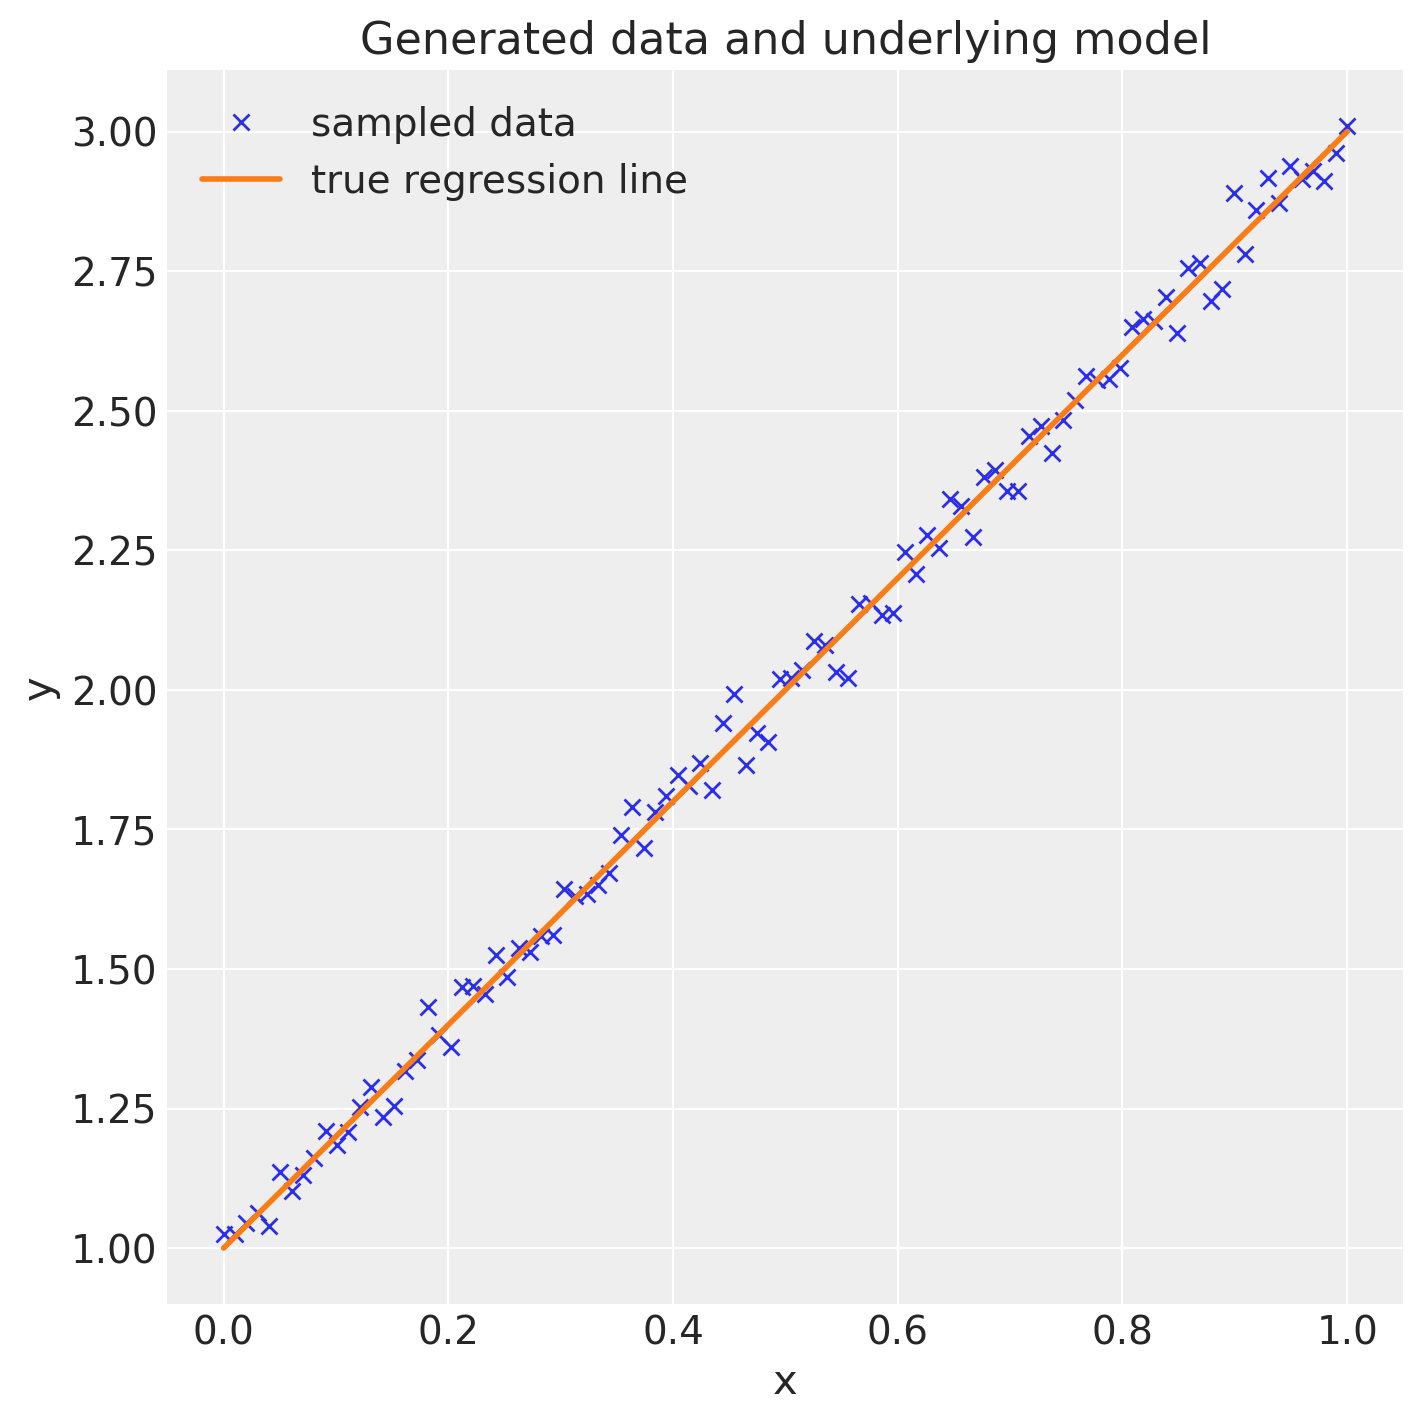

In [70]:
# Plot the data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

### Create a theano op that implements the likelihood
In order to use variance reduction, the user needs to define a Theano Op that calculates the forward model 
(or both the forward model and the likelihood).
Also, this Op needs to save the quantity of interest to a model variable with the name `Q`.
Here we use a Theano Op that contains both the forward model (i.e. the linear equation in this case) and the likelihood calculation. The quantity of interest is calculated with the perform() function and it is the mean of linear predictions given theta from all data points.

In [71]:
class Likelihood(tt.Op):
    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a scalar (likelihood)
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, x, y, pymc3_model):
        """
        Initialise the Op with various things that our likelihood requires.
        Parameters
        ----------        
        x:
            The x points. 
        y:
            The y points.
        pymc3_model:
            The pymc3 model.
        """
        self.x = x
        self.y = y
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        # this uses the linear model to calculate outputs
        temp = intercept + x_coeff * self.x
        # this saves the quantity of interest to the pymc3 model variable Q
        self.pymc3_model.Q.set_value(temp.mean())
        # this calculates the likelihood value
        outputs[0][0] = np.array(- (0.5 / s ** 2) * np.sum((temp - self.y) ** 2))

### Define the coarse models
Here we create the coarse models for MLDA. 
We need to include a `pm.Data()` variable `Q` in each one of those models, instantiated at `0.0`. These variables are set during sampling when the Op code under `perform()` runs.

In [72]:
mout = []
coarse_models = []

# Set up models in pymc3 for each level - excluding finest model level
# Level 0 (coarsest)
with pm.Model() as coarse_model_0:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data('Q', np.float(0.0))

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)
    
    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])
    
    # Here we instatiate a Likelihood obhect using the class defined above 
    # and we add to the mout list. We pass the coarse data x_coarse_0 and y_coarse_0
    # and the coarse pymc3 model coarse_model_0. This creates a coarse likelihood.
    mout.append(Likelihood(x_coarse_0, y_coarse_0, coarse_model_0))
    
    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_0)

# Level 1
with pm.Model() as coarse_model_1:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data('Q', np.float(0.0))

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)
    
    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])
    
    # Here we instatiate a Likelihood obhect using the class defined above 
    # and we add to the mout list. We pass the coarse data x_coarse_1 and y_coarse_1
    # and the coarse pymc3 model coarse_model_1. This creates a coarse likelihood.
    mout.append(Likelihood(x_coarse_1, y_coarse_1, coarse_model_1))
    
    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential('likelihood', mout[1](theta))

    coarse_models.append(coarse_model_1)

### Define the fine model and sample
Here we define the fine (i.e. correct) model and sample from it using MLDA (with and without variance reduction).
Note that `Q` is used here too.

We create two MLDA samplers, one with VR activated and one without.

In [73]:
with pm.Model() as model:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data('Q', np.float(0.0))

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)
    
    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])
    
    # Here we instatiate a Likelihood object using the class defined above 
    # and we add to the mout list. We pass the fine data x and y
    # and the fine pymc3 model model. This creates a fine likelihood.
    mout.append(Likelihood(x, y, model))
    
    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential('likelihood', mout[-1](theta))
    
    # MLDA with variance reduction
    step_with = pm.MLDA(coarse_models=coarse_models,                
                subsampling_rates=nsub,
                variance_reduction=True)
    
    # MLDA without variance reduction
    step_without = pm.MLDA(coarse_models=coarse_models,                
                subsampling_rates=nsub,
                variance_reduction=False,
                store_Q_fine=True)
    
    # sample
    trace1 = pm.sample(draws=ndraws, step=step_with,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)
    
    trace2 = pm.sample(draws=ndraws, step=step_without,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)

/Users/gmingas/projects/pymc3/pymc3/step_methods/mlda.py:458: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


### Show stats summary

In [74]:
pm.stats.summary(trace1)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.002,0.039,0.933,1.080,0.001,0.001,2487.0,2481.0,2501.0,2887.0,1.0
x,1.996,0.067,1.875,2.123,0.001,0.001,2535.0,2535.0,2537.0,2862.0,1.0


In [75]:
pm.stats.summary(trace2)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.003,0.04,0.932,1.077,0.001,0.001,2139.0,2121.0,2147.0,2402.0,1.0
x,1.993,0.07,1.860,2.119,0.001,0.001,2434.0,2434.0,2446.0,2804.0,1.0


### Show traceplots

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

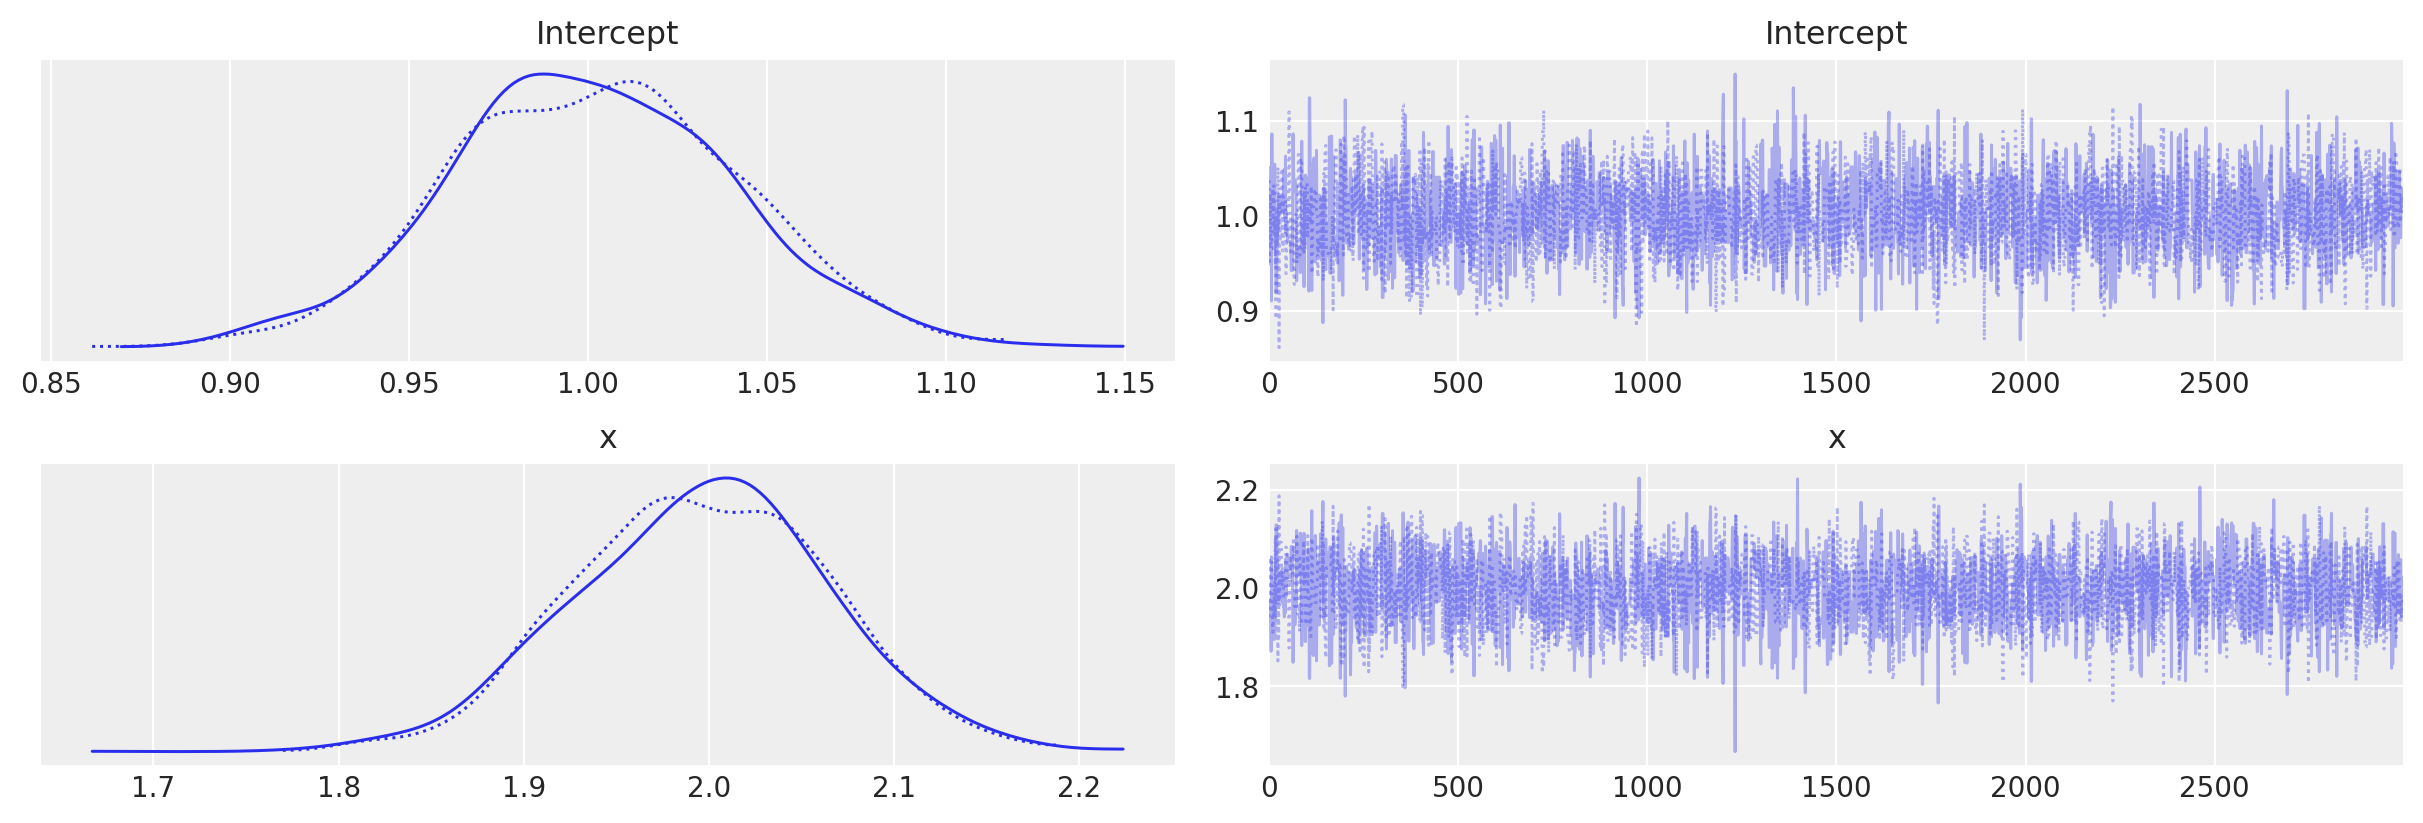

In [76]:
pm.plots.traceplot(trace1)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

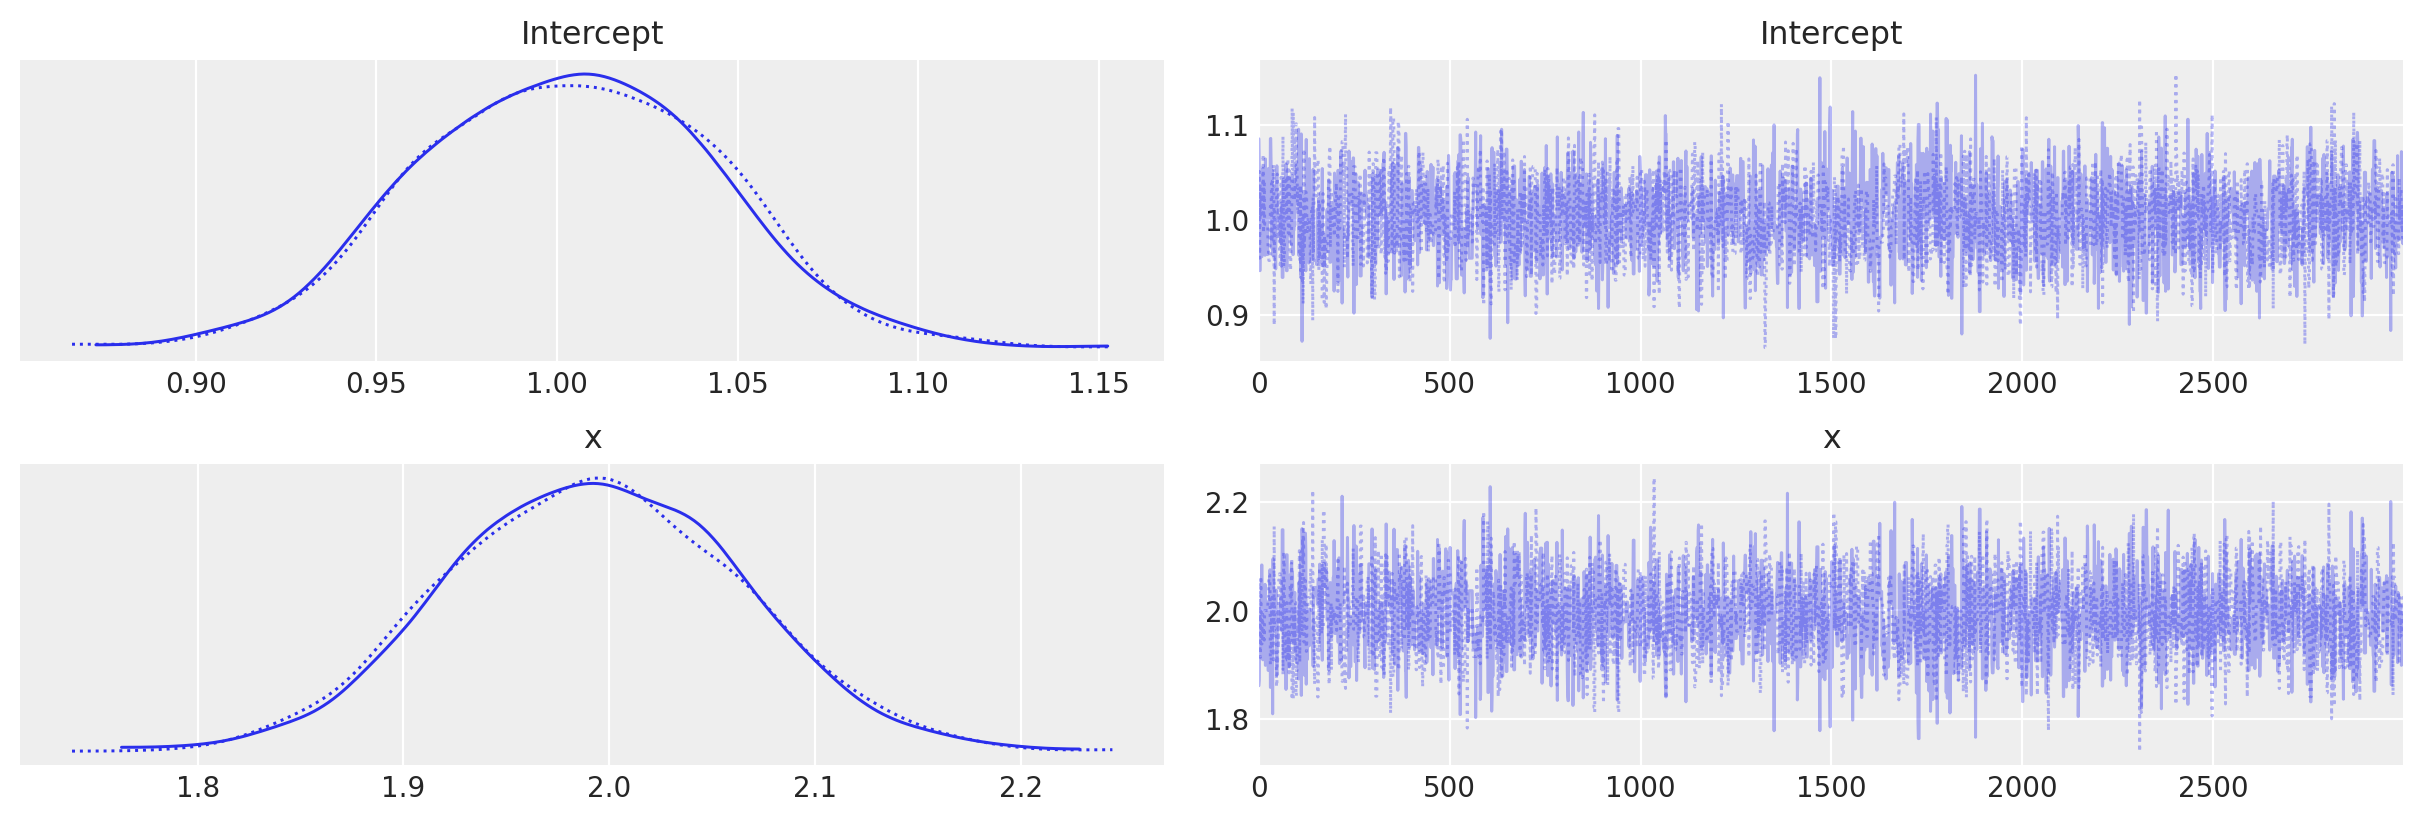

In [77]:
pm.plots.traceplot(trace2)

### Estimate standard error of two methods
Compare standard error of Q estimation between:
- Standard approach: Using only Q values from the fine chain (Q_2) - samples from MLDA without VR
- Collapsing sum (VR) approach: Using Q values from the coarsest chain (Q_0), plus all estimates of differences between levels (in this case Q_1_0 and Q_2_1) - samples from MLDA with VR

#### 1) Extract quantities of interest from the traces
This requires some reshaping with numpy

In [78]:
# MLDA without VR
Q_2 = trace2.get_sampler_stats("Q_2").reshape((nchains, ndraws))

# MLDA with VR
Q_0 = np.concatenate(trace1.get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace1.get_sampler_stats("Q_1_0")).reshape((nchains, ndraws * nsub))
Q_2_1 = np.concatenate(trace1.get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))

# Estimates
Q_mean_standard = Q_2.mean()
Q_mean_vr = Q_0.mean() + Q_1_0.mean() + Q_2_1.mean()

print(f"Q_0 mean = {Q_0.mean()}")
print(f"Q_1_0 mean = {Q_1_0.mean()}")
print(f"Q_2_1 mean = {Q_2_1.mean()}")
print(f"Q_2 mean = {Q_2.mean()}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")

Q_0 mean = 2.000553055055296
Q_1_0 mean = -0.010069727227140116
Q_2_1 mean = 0.010080508904420811
Q_2 mean = 1.9995146521264302
Standard method:    Mean: 1.9995146521264302
VR method:    Mean: 2.0005638367325767


#### Calculate variances of Q quantity samples
This shows that the variances of the differences is orders of magnitude smaller than the variance of any of the chains

In [79]:
Q_2.var()

0.0003887156725240976

In [80]:
Q_0.var()

0.0010760873150945423

In [81]:
Q_1_0.var()

2.3175382954631006e-07

In [82]:
Q_2_1.var()

1.1469959605972495e-07

#### Calculate standard error of each term using ESS

In [83]:
ess_Q0 = az.ess(np.array(Q_0, np.float64))
ess_Q_1_0 = az.ess(np.array(Q_1_0, np.float64))
ess_Q_2_1 = az.ess(np.array(Q_2_1, np.float64))
ess_Q2 = az.ess(np.array(Q_2, np.float64))

In [84]:
# note that the chain in level 2 has much fewer samples than the chain in level 0 (because of the subsampling rates)
print(ess_Q2, ess_Q0, ess_Q_1_0, ess_Q_2_1)

2394.931793573987 21358.15969118878 8295.594069507299 2536.564639416223


Standard errors are estimated by $Var(Q) \over ESS(Q)$. 
It is clear that the differences have standard errors much lower than levels 0 and 2

In [85]:
Q_2.var()/ess_Q2

1.623076170966908e-07

In [86]:
Q_0.var()/ess_Q0

5.038296045414801e-08

In [87]:
Q_1_0.var()/ess_Q_1_0

2.7936978063835595e-11

In [88]:
Q_2_1.var()/ess_Q_2_1

4.521847946525126e-11

#### Calculate total standard errors of the two competing estimates with different chunks of the sample
The graph shows how the errors decay when we collect more samples, demonstrating the gains of the VR technique in terms of standard error reduction.

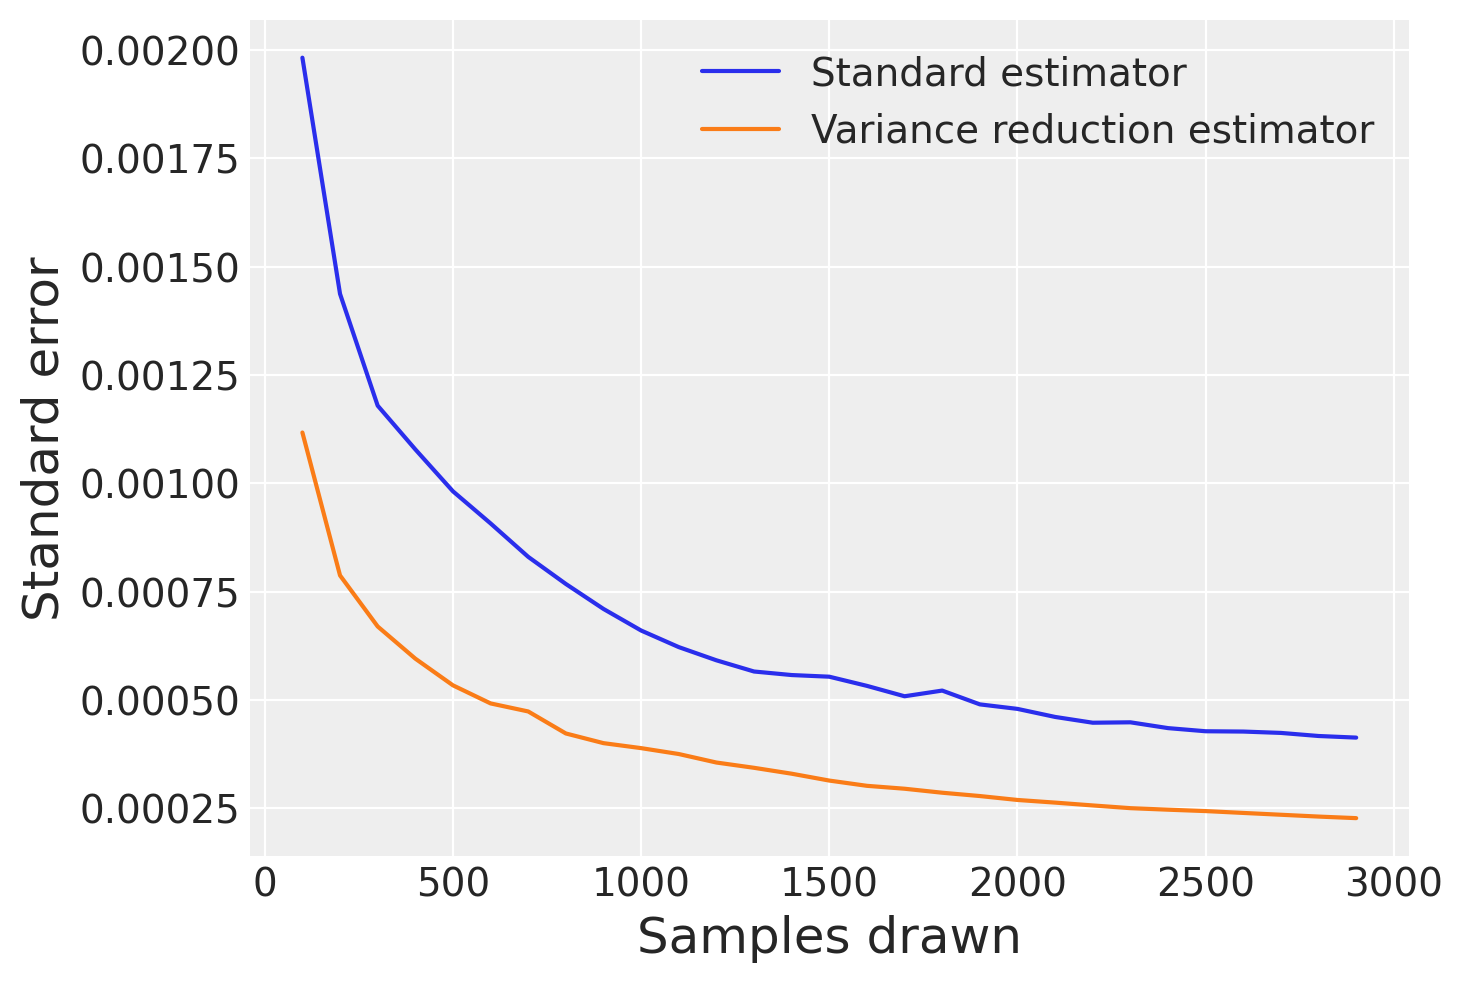

In [89]:
step = 100

Q2_SE = np.zeros(int(ndraws/step)-1)
Q0_SE = np.zeros(int(ndraws/step)-1)
Q_1_0_SE = np.zeros(int(ndraws/step)-1)
Q_2_1_SE = np.zeros(int(ndraws/step)-1)
E_standard_SE = np.zeros(int(ndraws/step)-1)
E_VR_SE = np.zeros(int(ndraws/step)-1)
k = 0

for i in np.arange(step, ndraws, step):
    Q2_SE[k] = Q_2[:,0:i].var() / az.ess(np.array(Q_2[:,0:i],np.float64))
    Q0_SE[k] = Q_0[:,0:i*(nsub**2)].var() / az.ess(np.array(Q_0[:,0:i*(nsub**2)],np.float64))
    Q_1_0_SE[k] = Q_1_0[:,0:i*nsub].var() / az.ess(np.array(Q_1_0[:,0:i*nsub],np.float64))
    Q_2_1_SE[k] = Q_2_1[:,0:i].var() / az.ess(np.array(Q_2_1[:,0:i],np.float64))
    E_standard_SE[k] = np.sqrt(Q2_SE[k])
    E_VR_SE[k] = np.sqrt(Q0_SE[k] + Q_1_0_SE[k] + Q_2_1_SE[k])
    k += 1

fig = plt.figure()
ax = fig.gca()

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.plot(np.arange(step, ndraws, step), E_standard_SE)
ax.plot(np.arange(step, ndraws, step), E_VR_SE)
plt.xlabel('Samples drawn', fontsize=18)
plt.ylabel('Standard error', fontsize=18)
ax.legend(['Standard estimator', 'Variance reduction estimator'])

In [90]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
arviz 0.9.0
pymc3 3.9.3
numpy 1.15.4
last updated: Wed Sep 30 2020 

CPython 3.6.11
IPython 7.16.1
watermark 2.0.2
